In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import random

In [2]:
# Define directories
image_directory = '../data/fish-behaviour/annotations/images/'  # Original Images
json_file = '../data/fish-behaviour/annotations/annotations/instances_default.json'  # JSON file

# Load the COCO annotations
coco = COCO(json_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [3]:
# Create a mapping from category_id to category_name
cats = coco.loadCats(coco.getCatIds())
category_mapping = {cat['id']: cat['name'] for cat in cats}
print("Category mapping:")
print(category_mapping)

Category mapping:
{1: 'Left', 2: 'Middle', 3: 'Right'}


In [4]:
def create_mask_from_annotation(ann, img_height, img_width):
    segmentation = ann['segmentation']
    
    if isinstance(segmentation, list):  # Polygon format
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        # Convert polygons to a mask
        for poly in segmentation:
            poly = np.array(poly).reshape((-1, 2))  # Reshape to (N, 2)
            cv2.fillPoly(mask, [np.int32(poly)], 1)  # Fill the polygon with 1's

    elif isinstance(segmentation, dict) and 'counts' in segmentation:  # RLE format
        rle = segmentation
        if isinstance(rle['counts'], list):  # Uncompressed RLE
            rle = maskUtils.frPyObjects([rle], img_height, img_width)
        mask = maskUtils.decode(rle)  # Decode RLE to binary mask

    else:
        mask = None  # Segmentation format not recognized

    return mask

In [5]:
# Get all image IDs
image_ids = coco.getImgIds()
print(f"Total number of images: {len(image_ids)}")

Total number of images: 166


In [6]:
# Create a color palette for different categories
num_categories = len(category_mapping)
random.seed(42)  # For reproducibility
colors = {cat_id: [random.randint(0, 255) for _ in range(3)] for cat_id in category_mapping.keys()}

Processing image ID 1, name frame_000001.png
Number of annotations for image frame_000001.png: 3
Processing annotation ID 1, category ID 2, category name Middle
Processing annotation ID 2, category ID 1, category name Left
Processing annotation ID 3, category ID 3, category name Right


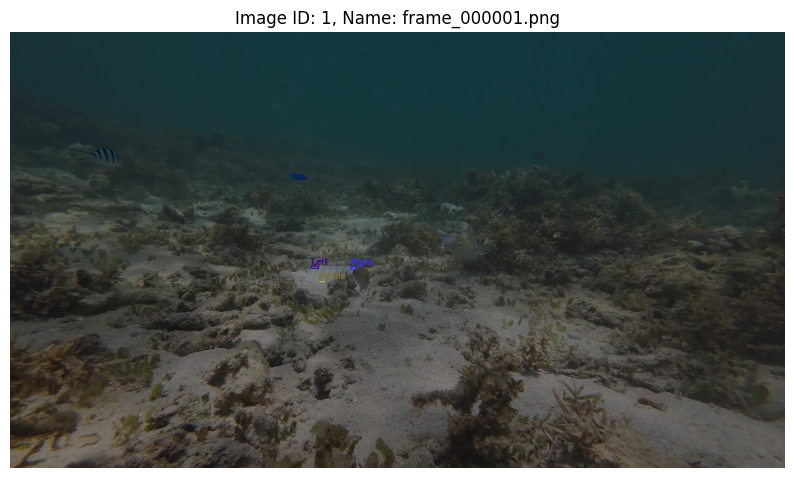

Processing image ID 2, name frame_000002.png
Number of annotations for image frame_000002.png: 3
Processing annotation ID 4, category ID 2, category name Middle
Processing annotation ID 5, category ID 1, category name Left
Processing annotation ID 6, category ID 3, category name Right


KeyboardInterrupt: 

In [8]:
# Process each image
for img_id in image_ids:
    # Load image information
    img_info = coco.loadImgs(img_id)[0]
    img_name_with_ext = img_info['file_name']  # e.g., 'frame_000001.png'
    img_name = os.path.splitext(img_name_with_ext)[0]  # e.g., 'frame_000001'
    img_height = img_info['height']
    img_width = img_info['width']
    
    print(f"Processing image ID {img_id}, name {img_name_with_ext}")

    # Load the original image
    img_path = os.path.join(image_directory, img_name_with_ext)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image {img_name_with_ext}")
        continue

    # Convert BGR to RGB for visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a blank mask for all annotations
    mask = np.zeros((img_height, img_width), dtype=np.uint8)

    # Get annotation IDs for the image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    
    print(f"Number of annotations for image {img_name_with_ext}: {len(anns)}")
    
    # Overlay masks on the image
    for ann in anns:
        category_id = ann['category_id']
        category_name = category_mapping.get(category_id, "Unknown")
        print(f"Processing annotation ID {ann['id']}, category ID {category_id}, category name {category_name}")
        
        # Create mask for the annotation
        ann_mask = create_mask_from_annotation(ann, img_height, img_width)
        if ann_mask is None:
            print(f"Failed to create mask for annotation {ann['id']}")
            continue  # Skip if mask couldn't be created

        # Assign a unique value to each category in the mask
        mask[ann_mask == 1] = category_id

    # Create a color mask
    color_mask = np.zeros_like(image_rgb)
    for category_id in np.unique(mask):
        if category_id == 0:
            continue  # Skip background
        color = colors[category_id]
        color_mask[mask == category_id] = color

    # Blend the original image and the color mask
    alpha = 0.5  # Transparency factor
    blended = cv2.addWeighted(image_rgb, 1 - alpha, color_mask, alpha, 0)

    # Optional: Draw category names
    for ann in anns:
        bbox = ann['bbox']  # [x, y, width, height]
        x, y, w, h = bbox
        category_id = ann['category_id']
        category_name = category_mapping.get(category_id, "Unknown")
        color = [int(c) for c in colors[category_id]]
        cv2.rectangle(blended, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)
        cv2.putText(blended, category_name, (int(x), int(y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Display the blended image using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(blended)
    plt.title(f"Image ID: {img_id}, Name: {img_name_with_ext}")
    plt.axis('off')
    plt.show()